# Cluster Analysis in R

## What is clustering?

Clustering refers to statistical methods that try to group observations (here samples) into meaningful clusters that share common characteristics (here abundances). Sharing of characteristics means that the methods create clusters such that members are most similar to members in the same cluster and most dissimilar to members of a different cluster. In the context of bacterial abundance analyses, this could be a distance metric such as Aitchison distance (Euclidean distance of CLR-transformed abundances). Each sample has the abundances as "coordinates" that are used to calculate the distance to another sample. In general, if the features would not be comparable (e.g. height and weight) we need to standardize them. When analyzing bacterial abundances all features are comparable. 

Note: It is also possible to do cluster analyses with binary data. In that case we can use a similarity score called the Jaccard index (J). The distance is then defined as 1 - similary score, thus 1 - J. To calculate this metric in R, we can use the dist function with `method = "binary"`. If we have more than 2 categories, we can create dummy variables. So, each category becomes a column and the rows are the observations that can be 0 or 1. We can do this using `dummy.data.frame` from the package *dummies*.

### General steps
1. Preprocess data: Data must be complete and on a similar scale
2. Select a (dis)similarity measure
3. Choose clustering method and perform
4. Analyze output and determine meaningfulness
5. Repeat until you reach a meaningful grouping of data


## Problems with the Concept of Enterotypes  
[Dan Knights and colleagues](https://www.ncbi.nlm.nih.gov/pubmed/25299329) point out that the statistical concepts how to look for biomarkers of diseases related to the gut microbiota is still in early development. The earlier description of distinct enterotypes that could be identified by unsupervised cluster analyses has to be interpreted with caution. Compared to methods that directly associate an oucome with the microbiota composition, using clusters might disregard information inherent in a continuous gradient. If a cluster analysis indentifies clusters, this could also simply reflect sampling of extreme environments rather than enterotypes (e.g. ketogenic diet vs low fat/highcarb diet samples might result in visible clusters). The meaningfulness usually requires expert knowledge that is combined with data driven indeces that can be used to determine if there is clustering based on features. Finally, they tracked a healthy individual and showed that it would fluctuate between three clusters that have been described earlier. 

Despite these problems clustering is still a common approach and should be part of the biostatisical toolbox. In the following, I shortly describe hierarchical clustering, K-means clustering and finally Dirichlet Multinomial Mixture Modeling as commonly used techniques.


## Hierarchical Clustering

Assume we have 4 samples and want to determine if sample 2 or sample 3 is closer to the group [sample 1 AND sample 4]. We could calculate the maximum distance from sample 2 to 1 and 2 to 4 (max(D(2,1), D(2, 4))) as well as max(D(3,1), D(3, 4)) where D refers to the distance metric used. Then we say based on the maximum distance, sample 2 (or 3) is closer. Hierachical clustering continous this idea. The algorithm starts by grouping 2 observations with the shortest distance. Then, each observation is evaluated in terms of distance and the closest one will be added to the group to build the second group etc.. At the end, there is one cluster containing all observations. If we go down to the next "level", we have two clusters etc.. There are different **linkage methods** to create the clusters. The most common are **complete linkage** (based on max distance), **single linkage** (based on min distance) and **average linkage**.

To perform hierarchical clustering we can use:

`hclust(distance_matrix, method = "complete")` 

Then to extract the cluster of a sample:  
`cutree(clusterobject, k = 2)`

We can then add this to our (meta-) dataframe and use PCA to visualize colored by clustering to see if the data separates well by the clusters. Furthermore, we can check whether belonging to a cluster is predictive of an outcome. To make biological sense of that we could compare the cluster for differential abundances, alpha diversity etc..  Here is a [Datacamp overview](https://www.statmethods.net/advstats/cluster.html) about clustering methods.

### Hierarchical Clustering in R

Here is a short demonstration using the dietswap dataset from the microbiome package.

In [6]:
library(microbiome)
library(tidyverse)
library(vegan)
library(cluster)
library(furrr)
data(dietswap)
source("https://raw.githubusercontent.com/HenrikEckermann/in_use/master/mb_helper.R")

In [7]:
# prepare data objects for analysis and visualization
pseq <- transform(dietswap, transform = "clr")
otus <- otu_to_df(pseq) %>% column_to_rownames("sample_id")
# I use Aitchison distance as distance metric
ait_dist <- dist(otus, method = "euclidean")
# store sample data in df for later
df <- sd_to_df(pseq) 

Warning message in class(x) <- c(subclass, tibble_class):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”

In [8]:
# perform cluster analysis
cluster <- hclust(ait_dist, method = "complete")

In [9]:
# extract clusters and add to dataframe
df <- cutree(cluster, k = 2) %>% as.data.frame() %>%
    rownames_to_column("sample_id") %>%
    rename(cluster = ".") %>%
    right_join(df, by = "sample_id")
# store in pseq to then show biplot
sample_data(pseq) <- df_to_sd(df)

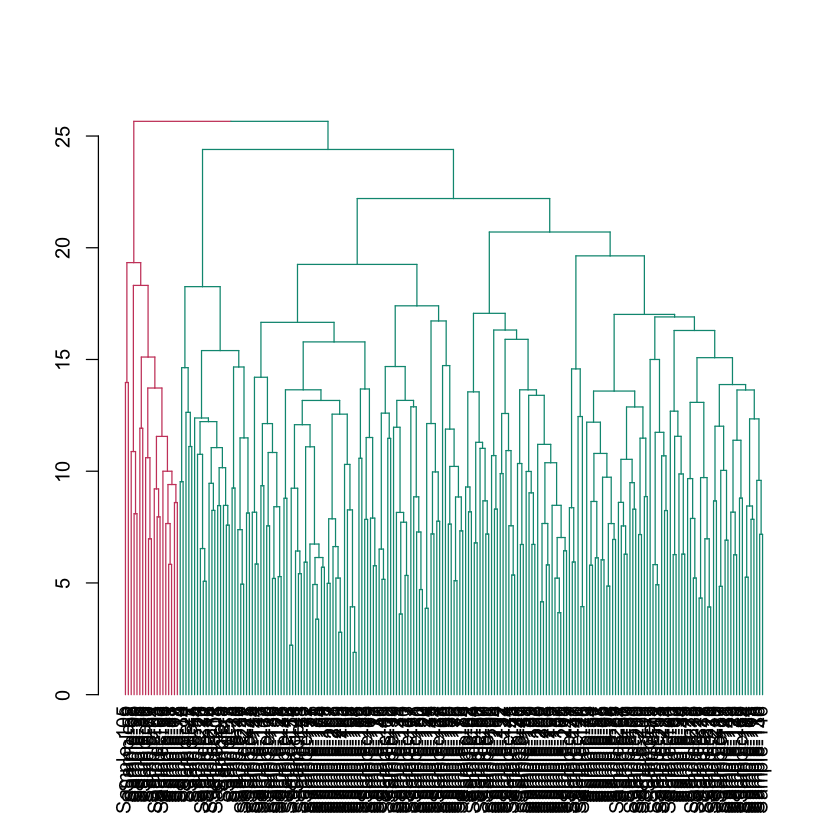

In [60]:
# dendogram
library(dendextend)

dend_samples <- as.dendrogram(cluster)  %>% color_branches(k = 2) 
dend_samples  %>% plot()

Warning message:
“`as.tibble()` is deprecated, use `as_tibble()` (but mind the new semantics).
This warning is displayed once per session.”Warning message in class(x) <- c(subclass, tibble_class):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”

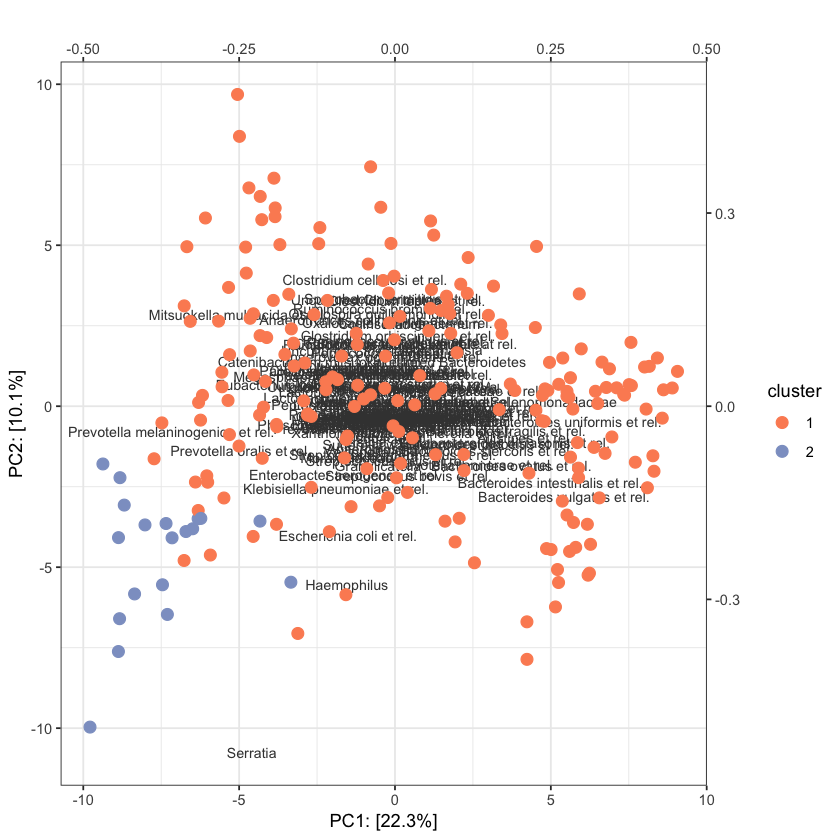

In [11]:
# from the knowledge we have about the data or from visualizing
# in two dimensions I cannot make sense of the clusters found by
# hierarchical clustering:
biplot(pseq, color = "cluster", scaling_factor = 20)[[1]]

In [12]:
# now, this is the very basics of hierachical clustering. If we considered these clusters
# as sensible and they would appear also valid according to the criteria shown further
# below, we would describe the clusters in more detail. This is not proceededed here.

## K-means clustering
K-means clustering is a partinioning based clustering method that is limited to using euclidean distance as metric and where _k_ has to be defined beforehand. 

### Decide number of K
To decide abou the number of k, there are relative and absolute measures of cluster strength. The Calinski-Harabasz (CH) method is often used. However it only gives a measure about which _k_ is most likely assuming that there are clusters. [Koren et. al](https://journals.plos.org/ploscompbiol/article/file?id=10.1371/journal.pcbi.1002863&type=printable) recommend to use at least one absolute measure (better two). Absolute measures are the **silhouette index (SI)** and **predictive strength (PS)**. The SI can be used to determine how well observations fit into a cluster. For this we calculate the silhouette width for each observation by obtaining the within cluster distance $C_i$ (euclidean distance to the other members in the same cluster) and the closest neighbor distance $N_i$ (euclidean distance to the obserations in the closest cluster). The interpretation is as follows: a value closer to 1 means that an observation is well matched to it's cluster whereas 0 means it can belong to either cluster. Minus 1 indicates it would better fit in the other cluster. For example, [Koren et. al](https://journals.plos.org/ploscompbiol/article/file?id=10.1371/journal.pcbi.1002863&type=printable) used a score of 0.5 for moderate clustering as described by Wu et al., and $\geq 0.75$ for strong clustering. The silhouette width can be analysed using the function `pam` from the package *cluster*. PS refers to the accuracy of how well cluster matches between two subsamples of the data. [Koren et. al](https://journals.plos.org/ploscompbiol/article/file?id=10.1371/journal.pcbi.1002863&type=printable) applied a criterion of $\geq 0.90$ for PS to signify strong clustering (this implies that 90% of the data points fall within the cluster and 10% are outliers). Another method described in the datacamp course is the scree-plot (aka. ellbow method). You start with one cluster, calculate the total sum of the squared distance to the centroid. Then use k = 2 and again calculate the sum of squared distances to the closer cluster for all samples. Repeat for k = ...n. The sum will always further decrease as can be visualized in the **scree plot**. Pick the *k* where the plot starts to flatten out.

## Problems 
[Koren et. al](https://journals.plos.org/ploscompbiol/article/file?id=10.1371/journal.pcbi.1002863&type=printable) mention how distance metric, otu picking method, taxonomic level (genus vs species) and index (SI vs PS and CH) influence results and recommend to use more than one distance metric and in case you want to use clustering approach: explain very well based on which information you think that enterotypes could be validated. See also the other article cited above.

In [13]:
model <- kmeans(otus, centers = 2)

In [14]:
# again store in df
df <- model$cluster %>% 
    as.data.frame() %>%
    rownames_to_column("sample_id") %>%
    rename(kmeans = ".") %>%
    right_join(df, by = "sample_id")
# store in pseq to then show biplot ?!
sample_data(pseq) <- df_to_sd(df)

Warning message in class(x) <- c(subclass, tibble_class):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”

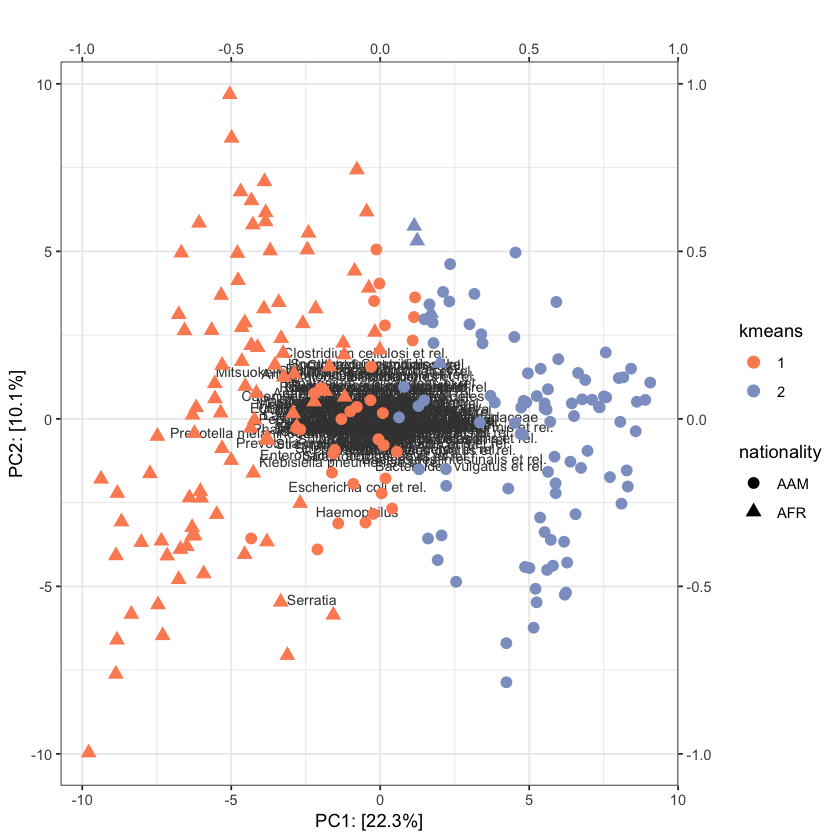

In [15]:
# interestingly, K-means can almost cluster by nationality, def more sensible
# than the result with hclust in this particular case
biplot(pseq, color = "kmeans", shape = "nationality")[[1]]

In [61]:
# if we would not know nationality we would evaluate clustering or at least define k
# from the data. here I use both the elbow plot but also silhouette width to determine 
# k based on that
total_within_ss <- map(1:10, function(k) {
    model_eb <- kmeans(x = otus, centers = k)
    model_pam <- pam(x = otus, k = k)
    c(k = k, withinss = model_eb$tot.withinss, sil =model_pam$silinfo$avg.width)
})

Warning message:
“Removed 1 rows containing missing values (geom_point).”Warning message:
“Removed 1 rows containing missing values (geom_path).”

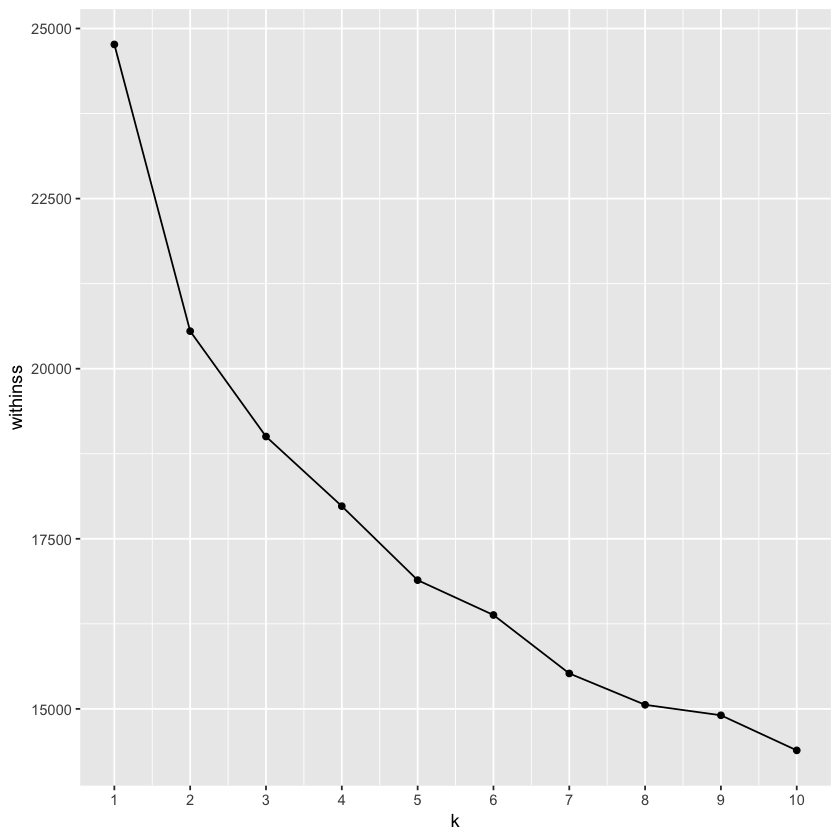

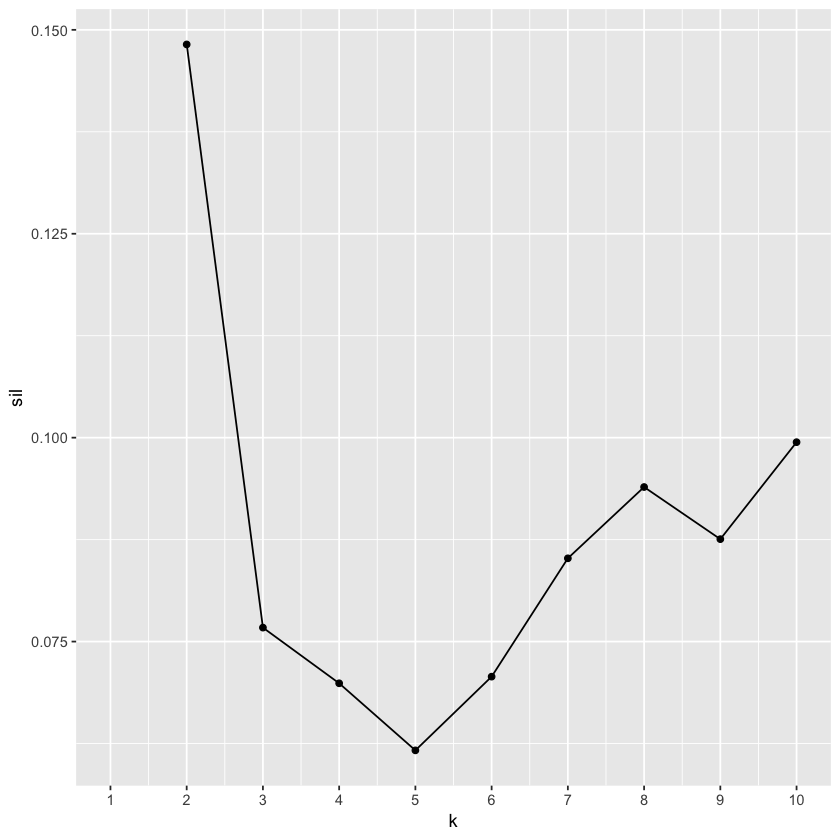

In [62]:
# SI would suggest k = 2 which is in line with what we see based on PCA. However, SI
# altogether is indicative of weak clustering and based on above criteria the value is
# too low (< 0.5)
total_within_ss %>% map_df(bind_rows) %>%
    ggplot(aes(k, withinss)) +
    geom_point() +
    scale_x_continuous(breaks = c(0:10)) +
    geom_line()
total_within_ss %>% map_df(bind_rows) %>%
    ggplot(aes(k, sil)) +
    geom_point() +
    scale_x_continuous(breaks = c(0:10)) +
    geom_line()

## Dirichlet Multinomial Mixture Models [(DMM)](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0030126)

We have seen hierarchical clustering, where a tree of relationships is generated and the grouping takes place by setting an arbitrary cut-off. This is commonly used in microbial community analyses (time of paper [2012](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0030126)). Furthermore, we have seen k-means as a method of partitional clustering. These methods are not specifically designed to model 16S-sequencing data, which is count data that is sparse. Even if we normalize count data into relative abundance, it remains fundamentally count data (this is also true for HITChip data, which could be be discretized to use DMM). Finally, the samples vary in the number of reads, which causes low read samples to be more noisy than larger samples. The [Dirichlet multinomial mixture model](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0030126) (DMM) is a generative modeling framework that addresses the need for a model that accounts for the specifics of 16S sequencing data. This model can be used for clustering (model based clustering approach) and also for classification.

In this approach, we stop viewing samples as representing the communtiy but we assume samples are generated by sampling from the community with replacement. This implies a multinomial likelihood function with a parameter vector where a given entry represents the probability that a read is from a particular taxa. In the limit, this vector would result in the real proportions of the abundances in the community. A natural prior for the parameters of this model is the Dirichlet distribution, which is a probability distribution over probability vectors. In the context of microbial communities we can view it as describing a metacommunity from which communities can be sampled. The parameters reflect the mean expected communitiy and the variance in communities. Then, by using a mixture Dirichlet, the model assumes different metacommunities, which makes the model more flexible and eligible for clustering. A sample gets assigned to that metacommunity (cluster), which it most likely originates from according to the model. The clusters can be of different sizes depending on the variablity of the metacommunity. Also, since we now have a probability model we can use the evidence together with methods to penalise model complexity to provide a means of determining optimal cluster number.

- $X_{ij}$ = matrix with samples (*i*) as rows and taxa (_j_) as columns
- $S$ = total number of taxa
- $N$ = total number of communities (samples)
- $\bar{X_i}$ = Rows of the matrix (there are N vectors ($\bar{X_i}$) with length S)
- We assume that each sample is generated from a multinomial distribution with parameter vector $\bar{p_i}$
- The elements of $\bar{p_i}$ ($p_{ij}$) are the probabilities that an individual read taken from communitiy *i* belongs to species _j_.
- The multinomial distribution corresponds to sampling with replacement from the community, which gives a likelihood for observing each community sample:  
$L_i(\bar{X}_i|\bar{p}_i) = J_i! \displaystyle\prod_{j=1}^{S} \frac{p_{ij}^{X_{ij}}}{X_{ij}!}$,   

where $J_i=\sum_{j=1}^{S} X_{ij}$ (total number of reads per sample _i_)

The total likelihood is the product of the community sample likelihoods:  

$L(X|\bar{p}_1,..., \bar{p}_N = \displaystyle\prod_{i=1}^{N} L_i(\bar{X}_i|\bar{p}_i$

In the Bayesian approach a prior needs to be defined for the parameter vector $p_i$, which is given by the Dirichlet (distribution of probabilities). The Dirichlet prior has S parameters $\alpha$ that can be expressed as a vector $\bar{\alpha}$. $\alpha$ can be expressed as $\theta\bar{m}$ where $\theta$ is the sum of all $\alpha_j$ and $m$ is a normalised measure where $m_j$ reflects the mean $p_{ij}$ values. The value $\theta$ then acts like a precision how close the values are to that mean. Large $\theta$ means little variance around the mean value while small $\theta$ means large variation of samples. The Dirchlet Mixture priors then reflect the underlying structure of the community _i_ (please see the paper if the mathematical formula is of interest). To allow clustering the Dirichlet prior is extended to a mixture of *K* Dirichlets, indexed $k=1, ...K$ each with parameters $\bar{\alpha}_k$ and weight $\pi_k$. Each community vector $\bar{p}_i$ is assumed to derive from a single metacommunity.  

### Model comparison through Laplace approximation  

To determine the number of components $K$ in the Dirichlet mixture a Laplace approximation is used to navigate between overfitting and model simplicity, both of which would lead to bias. The minimum value represents the model with the highest propbability.

Below I show how to fit a DMM with the dietswap data.

In [19]:
library(DirichletMultinomial)

In [20]:
# first using the dietswap data
otu <- dietswap %>% otu_table() %>% t()
colnames(otu) <- clean_otu_names(colnames(otu))

In [21]:
# the dmn function fits a DMM model taking as input the count data
# and a parameter k representing the number of Dirichlet components
# here k from 1-7 is used:
k <- c(1:7)
fit_ds <- map(k, dmn, count = otu)

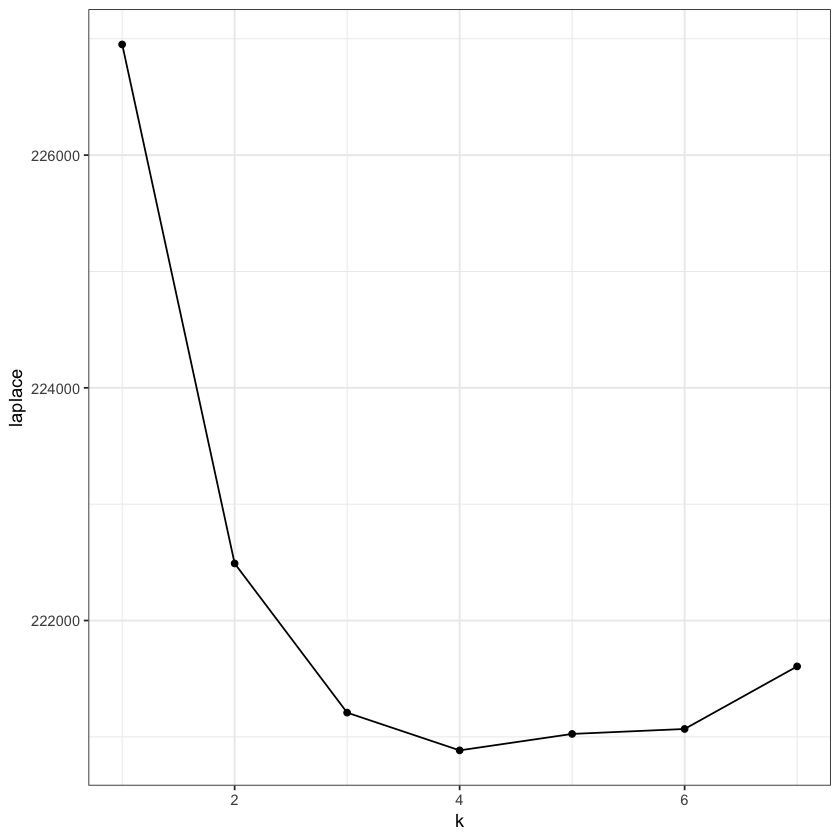

In [38]:
# The model objects contains measures of fit (Laplace, AIC, BIC)
# these can be plotted to find the most likely number of k: 4 in this case
fit_lap_ds <- map_dbl(fit_ds, laplace)
# plot laplace approximation
tibble(k = k, laplace = fit_lap2) %>%
    ggplot(aes(k, laplace)) +
    geom_point() +
    geom_line() +
    theme_bw()

In [37]:
# extract clusters 
assign_k <- as.data.frame(mixture(fit_ds[[4]], assign = T)) %>% 
    rownames_to_column("sample_id")
colnames(assign_k) <- c("sample_id", "DMM4")
# store cluster variable in pseq object
sample_data(pseq) <- pseq %>% 
    sd_to_df() %>%
    mutate(timepoint.within.group = as.factor(timepoint.within.group)) %>%
    left_join(assign_k, by = "sample_id") %>%
    df_to_sd()   

Warning message in class(x) <- c(subclass, tibble_class):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”

In [24]:
sd_to_df(pseq) %>% head()

Warning message in class(x) <- c(subclass, tibble_class):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”

kmeans,cluster,subject,sex,nationality,group,sample,timepoint,timepoint.within.group,bmi_group,DMM4,sample_id
2,1,byn,Male,AAM,DI,Sample-1,4,1,obese,1,Sample-1
1,1,nms,Male,AFR,HE,Sample-2,2,1,lean,3,Sample-2
1,1,olt,Male,AFR,HE,Sample-3,2,1,overweight,2,Sample-3
1,1,pku,Female,AFR,HE,Sample-4,2,1,obese,3,Sample-4
1,1,qjy,Female,AFR,HE,Sample-5,2,1,overweight,4,Sample-5
1,2,riv,Female,AFR,HE,Sample-6,2,1,obese,4,Sample-6


Warning message in class(x) <- c(subclass, tibble_class):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”Warning message in class(x) <- c(subclass, tibble_class):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”

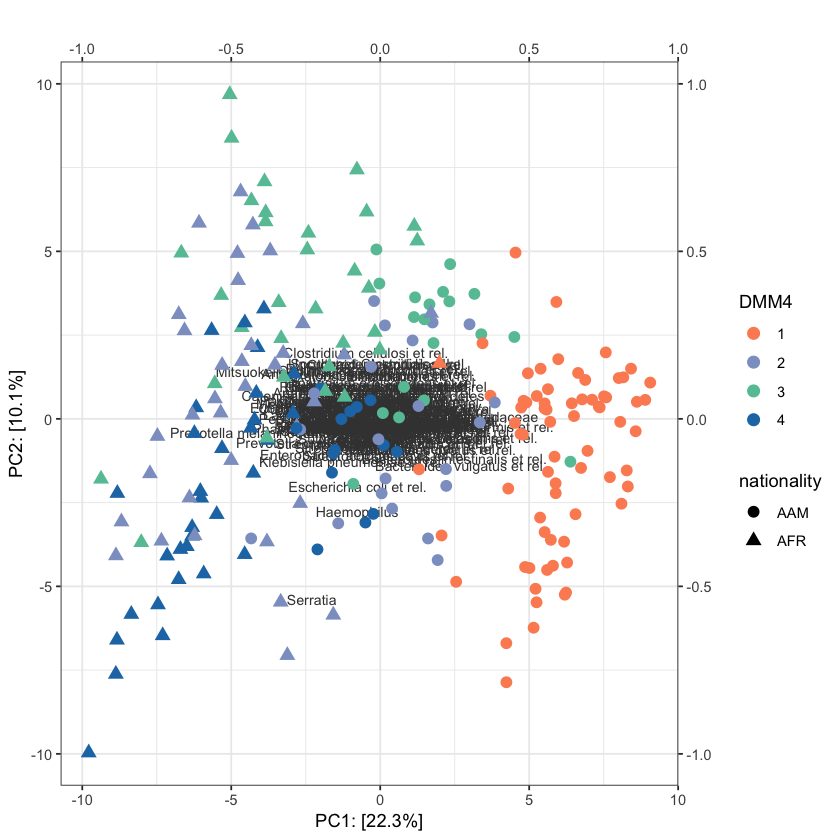

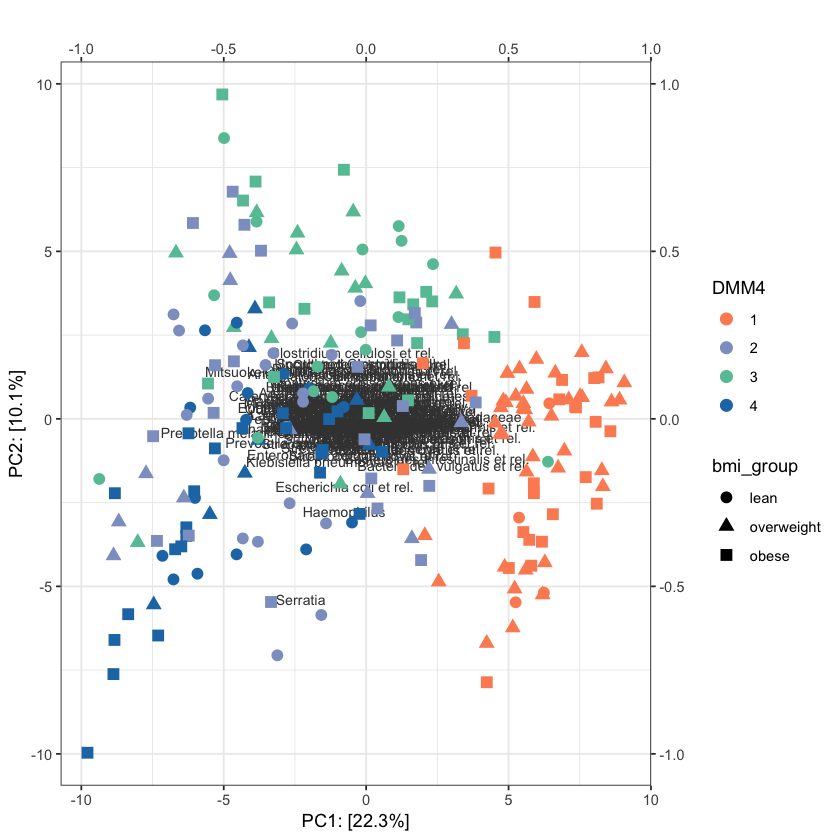

In [25]:
biplot(pseq, color = "DMM4", shape = "nationality")[[1]]
biplot(pseq, color = "DMM4", shape = "bmi_group")[[1]]

In [26]:
# contribution of each taxa for each cluster
fitted(fit_ds[[4]]) %>% 
    as.data.frame() %>% 
    log() %>% 
    head()

,V1,V2,V3,V4
Actinomycetaceae,-1.663713,-1.65904874,-1.6636854,-1.5111300
Aerococcus,-2.118982,-2.13225093,-2.1430550,-2.0189483
Aeromonas,-2.118982,-2.12816907,-2.1449617,-2.0067741
Akkermansia,0.337416,-0.09776734,0.2464384,0.0570761
Alcaligenesfaecalisetrel,-1.031874,-1.12748872,-1.1393973,-0.8856582
Allistipesetrel,1.881693,0.39588600,0.3857036,0.6636342


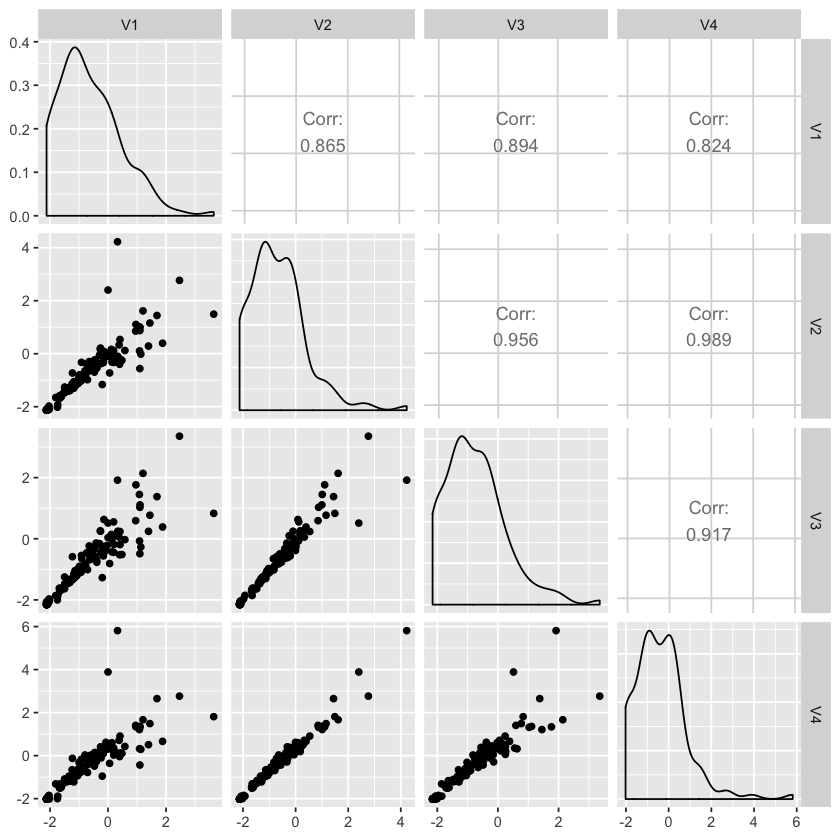

In [27]:
# plot contribution for each otu for each cluster
fitted(fit_ds[[4]]) %>% as.data.frame() %>% log() %>% GGally::ggpairs()

### Twin Data Set

*Below code is modified from the [reference manual](https://bioconductor.org/packages/release/bioc/html/DirichletMultinomial.html) of the package DirichletMultinomial*

In [28]:
# load otu table
otu_file <- system.file(package = "DirichletMultinomial", "extdata", "Twins.csv")
count <- t(as.matrix(read.csv(otu_file, row.names=1)))
# load meta data
meta_file <- system.file(package="DirichletMultinomial", "extdata", "TwinStudy.t")
meta0 <- scan(meta_file)
lvls <- c("lean", "obese", "overwt")
meta <- factor(lvls[meta0 + 1], levels = lvls)
names(meta) <- rownames(count)
meta <- as.data.frame(meta) %>% rownames_to_column("sample_id")

In [29]:
# figure timepoint from the sample name
meta <- meta %>% 
    mutate(timepoint = ifelse(grepl(".2", sample_id, fixed = T), 2, 1)) %>%
    select(everything(), bmi = meta)

In [30]:
# fit models
k <- c(1:7)
fit <- map(k, dmn, count = count)

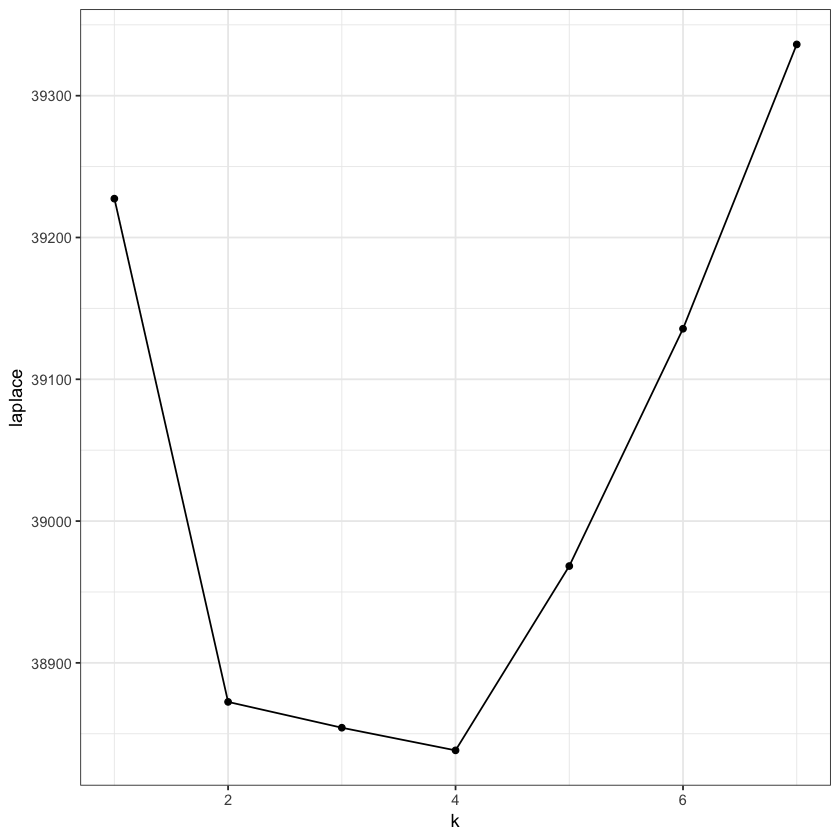

In [31]:
# model evidence
fit_lap <- map_dbl(fit, laplace)
tibble(k = k, laplace = fit_lap) %>%
    ggplot(aes(k, laplace)) +
    geom_point() +
    geom_line() +
    theme_bw() 

In [32]:
# the mixturewt function reports the weight pi and precision measure theta
# (large values are more homogeneous). Thus, we have 2 less abundant and highly variable
# cluster 3 and 4 (higher theta mean more homogeneous). And we have two more abundant 
# homogeneous clusters 1 and 2.
mixturewt(fit[[4]])

pi,theta
0.3108451,52.03690
0.3027758,53.29516
0.2197937,30.19585
0.1665855,18.72611


In [39]:
# I need to creat biplot manually since i have no pseq object:
# apply clr, perform pca, plot pcs
apply_clr <- function(x){log2(x) - mean(log2(x))}
# add minval to 0 as in tranform (phyloseq)
v <- as.vector(count)
minval <- min(v[v > 0])/2

In [40]:
count_clr <- count %>% 
    as.data.frame() %>%
    rownames_to_column("sample_id") %>%
    gather(genus, value, -sample_id) %>%
    spread(sample_id, value) %>%
    mutate_if(is.numeric, function(x) x + minval) %>%
    mutate_if(is.numeric, apply_clr) %>%
    gather(sample_id, value, -genus) %>%
    spread(genus, value) %>% 
    column_to_rownames("sample_id")

In [41]:
# bmi groups counts
meta %>% group_by(bmi) %>% summarise(n = n())

bmi,n
lean,61
obese,193
overwt,24


In [47]:
# pca 
pcr <- prcomp(count_clr)

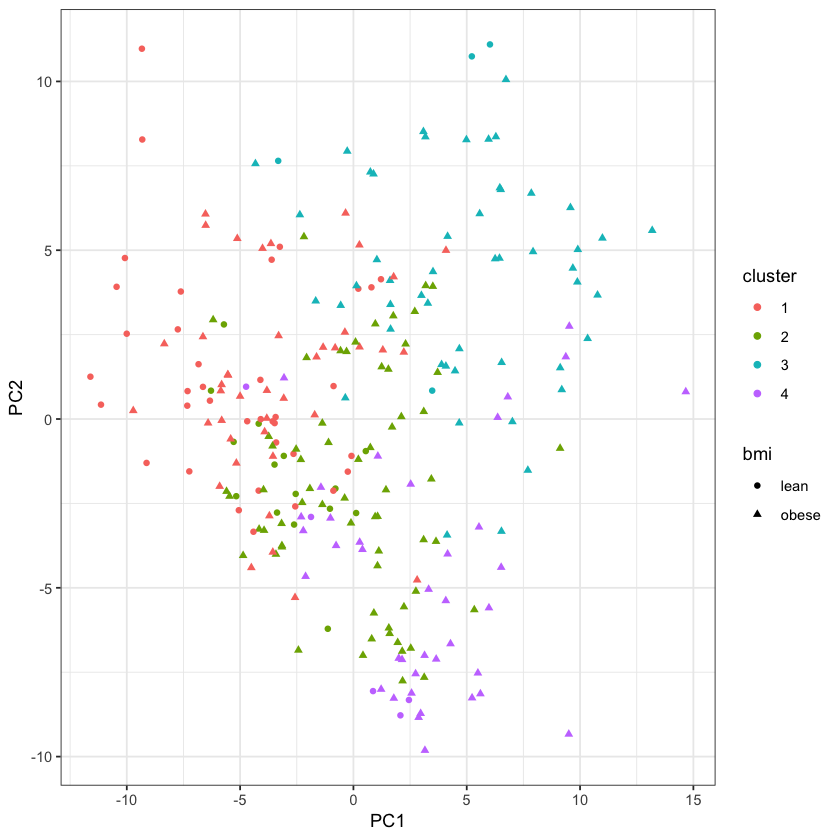

In [50]:
# assign cluster variable to meta
cluster_assign <- mixture(fit[[4]], assign = T) %>% 
    as.data.frame() %>%
    rownames_to_column("sample_id") 
colnames(cluster_assign) <- c("sample_id", "cluster")
pcr$x %>% as.data.frame() %>%
    rownames_to_column("sample_id") %>%
    left_join(cluster_assign, by = "sample_id") %>%
    left_join(meta, by = "sample_id") %>%
    mutate(cluster = as.factor(cluster), timepoint = as.factor(timepoint))%>%
    filter(bmi != "overwt") %>%
    ggplot(aes(PC1, PC2, shape = bmi, color = cluster)) +
    geom_point() +
    theme_bw()

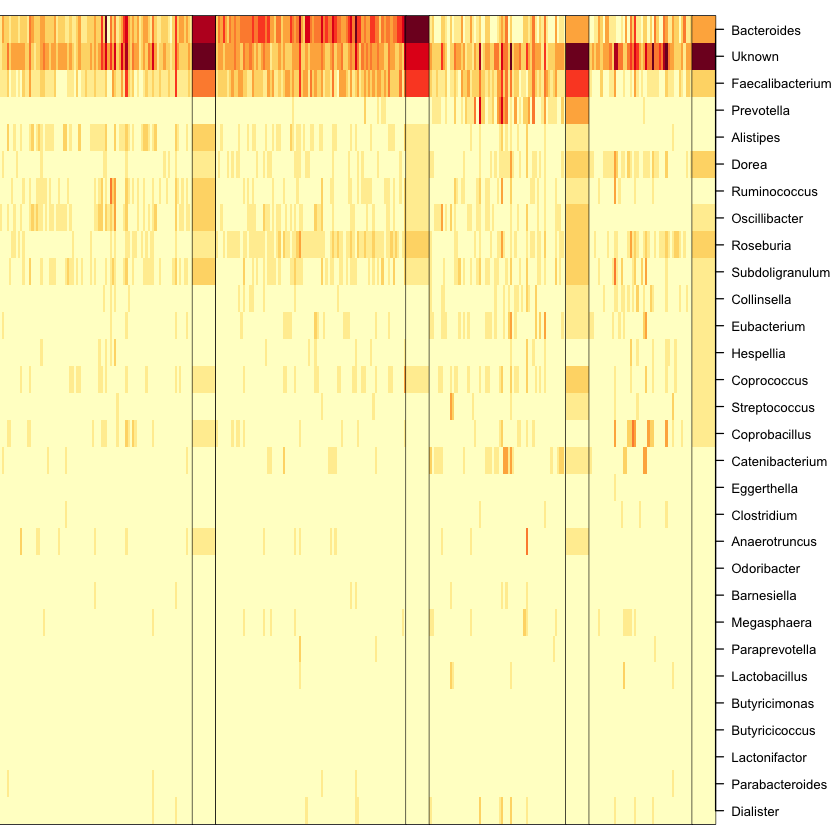

In [52]:
# abundances per sample and average of cluster:
heatmapdmn(count, fit[[1]], fit[[4]])